In [1]:
# Installing required library
!pip install kagglehub

In [ ]:
# Link -> https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
# https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/data?select=Meta


In [3]:
# Downloading the dataset
import kagglehub
path = kagglehub.dataset_download('meowmeowmeowmeowmeow/gtsrb-german-traffic-sign')
print('Path to the dataset files :', path)


Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.
Path to the dataset files : /kaggle/input/gtsrb-german-traffic-sign


In [4]:
# Importing important libraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Dataset Paths
base_dir =  '/kaggle/input/gtsrb-german-traffic-sign'

In [6]:
# Data Generators
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)
train_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)

val_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = True
)

print("Classes :", list(train_gen.class_indices.keys()))

Found 83014 images belonging to 6 classes.
Found 20750 images belonging to 6 classes.
Classes : ['Meta', 'Test', 'Train', 'meta', 'test', 'train']


In [7]:
# Sample Image Plot
def show_sample_images(generator):
  x, y = next(generator)
  plt.figure(figsize = (10, 3))
  for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x[i])
    plt.title(list(train_gen.class_indices.keys())[np.argmax(y[i])])
    plt.axis('off')
  plt.suptitle('Sample Original Images')
  plt.show()

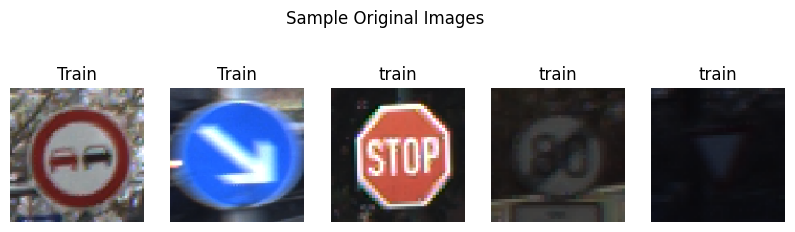

In [8]:
# Driver Code
show_sample_images(train_gen)

In [9]:
# Show Augmented Images
aug_datagen_display = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.3,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [10]:
# Function to get a random image path from a directory
def get_random_image_path(base_path):
  class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
  random_class_dir = random.choice(class_dirs)
  random_class_path = os.path.join(base_path, random_class_dir)
  images = os.listdir(random_class_path)
  random_image_name = random.choice(images)
  return os.path.join(random_class_path, random_image_name)

In [11]:
# Dynamically get a sample image path
sample_image_path = get_random_image_path(base_dir)
print(f"Using sample image from  : {sample_image_path}")

Using sample image from  : /kaggle/input/gtsrb-german-traffic-sign/Meta/1.png


In [12]:
# Getting the image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img = load_img(sample_image_path, target_size = (128, 128))
x = img_to_array(img)
x = x.reshape((1, ) + x.shape) # Reshape to (1, 128, 128, 3)

In [13]:
# Writing a function for augmented image
def show_augmented_images_with_originals(img_array, datagen, num_images = 4):
  plt.figure(figsize = (15, 5))

  # Display Original Image
  plt.subplot(1, num_images + 1, 1)
  plt.imshow(img_array.reshape(128,128, 3) / 255.0)
  plt.title('Original Image')
  plt.axis('off')

  # Display Augmented Images
  i = 2
  for batch in datagen.flow(img_array, batch_size = 1):
    plt.subplot(1, num_images + 1, i)
    plt.imshow(batch[0] / 255.0)
    plt.title(f"Augmented {i-1}")
    plt.axis('off')
    i += 1
    if i > num_images + 1:
      break

  plt.suptitle('ASample Images vs Augmented Images')
  plt.show()

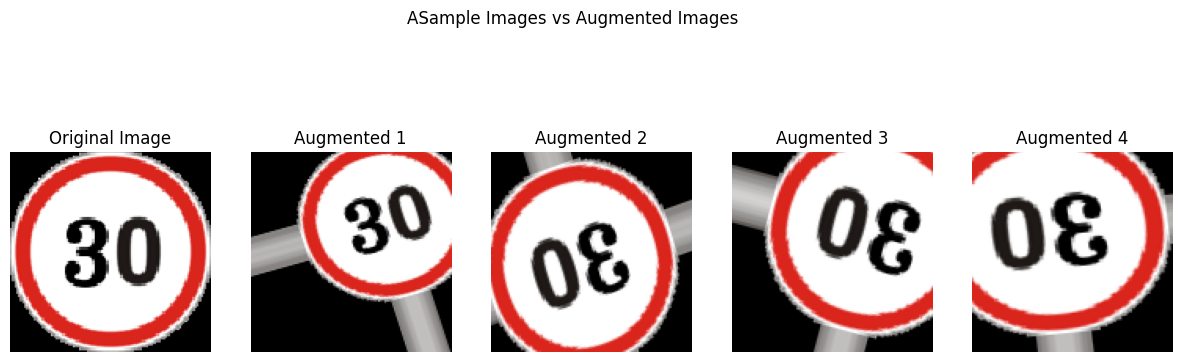

In [14]:
# Driver Code
show_augmented_images_with_originals(x, aug_datagen_display)

In [19]:
# Building the CNN Model
def build_cnn_model(num_filters = 32, num_hidden = 1, neurons = 64, dropout_rate = 0.3):
  model = Sequential()
  model.add(Conv2D(num_filters, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(num_filters*2, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())

  for _ in range(num_hidden):
    model.add(Dense(neurons, activation = 'relu'))
    model.add(Dropout(dropout_rate))

  model.add(Dense(len(train_gen.class_indices), activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model


In [20]:
# Training Multiple Models
configs = [
    {"num_filters": 32, "num_hidden": 1, "neurons": 64, "dropout_rate": 0.2},
    {"num_filters": 32, "num_hidden": 2, "neurons": 64, "dropout_rate": 0.3},
    {"num_filters": 32, "num_hidden": 1, "neurons": 64, "dropout_rate": 0.3}
]
# Early Stopping
early_stop = EarlyStopping(monitor = 'val_loss',  patience = 3, restore_best_weights = True)

In [21]:
# Loop
results = []
for cfg  in configs:
  print(f"\nTraining with config : {cfg}")
  model = build_cnn_model(**cfg)
  history = model.fit(
      train_gen,
      epochs = 10,
      validation_data = val_gen,
      callbacks = [early_stop],
      verbose = 1
  )
  val_acc = max(history.history['val_accuracy'])
  results.append((cfg, val_acc))


Training with config : {'num_filters': 32, 'num_hidden': 1, 'neurons': 64, 'dropout_rate': 0.2}
Epoch 1/10
2595/2595 ━━━━━━━━━━━━━━━━━━━━ 552s 211ms/step - accuracy: 0.3798 - loss: 1.2692 - val_accuracy: 0.2787 - val_loss: 1.4308
Epoch 2/10
2595/2595 ━━━━━━━━━━━━━━━━━━━━ 119s 46ms/step - accuracy: 0.3935 - loss: 1.1682 - val_accuracy: 0.1764 - val_loss: 1.9484
Epoch 3/10
2595/2595 ━━━━━━━━━━━━━━━━━━━━ 120s 46ms/step - accuracy: 0.4187 - loss: 1.0648 - val_accuracy: 0.1624 - val_loss: 3.1362
Epoch 4/10
2595/2595 ━━━━━━━━━━━━━━━━━━━━ 119s 46ms/step - accuracy: 0.4454 - loss: 0.9617 - val_accuracy: 0.1740 - val_loss: 3.8023

Training with config : {'num_filters': 32, 'num_hidden': 2, 'neurons': 64, 'dropout_rate': 0.3}
Epoch 1/10
2595/2595 ━━━━━━━━━━━━━━━━━━━━ 125s 47ms/step - accuracy: 0.3725 - loss: 1.3102 - val_accuracy: 0.3347 - val_loss: 1.4031
Epoch 2/10
2595/2595 ━━━━━━━━━━━━━━━━━━━━ 120s 46ms/step - accuracy: 0.3920 - loss: 1.1784 - val_accuracy: 0.1733 - val_loss: 2.1035
Epoch 3

In [ ]:
'''
All the models are overfitted.
'''

In [ ]:
# Getting the best model
print('\n Final Results :')
for cfg, acc in results:
  print(f"Config : {cfg} | Validation Accuracy : {acc}")


 Final Results :
